In [21]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import time

from copy import deepcopy
from math import ceil
import scipy, scipy.signal
from scipy.io.wavfile import write

- These functions here are used to play and to write sound on the user's directory. Note : play sound may not work on WSL, depending on the packages you have installed ! 

In [22]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

- Fetching the data to be played on the computer

In [23]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

- Getting the sound file's frequency information

In [24]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


- Playing the sound file (Reminder above for WSL users)

In [25]:
play = False
if play :
    play_sound(sound) 

- Getting the array fo the sound file 

In [26]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

- Getting the timesteps in order to plot the sound array

In [55]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

- Plotting the sound array 

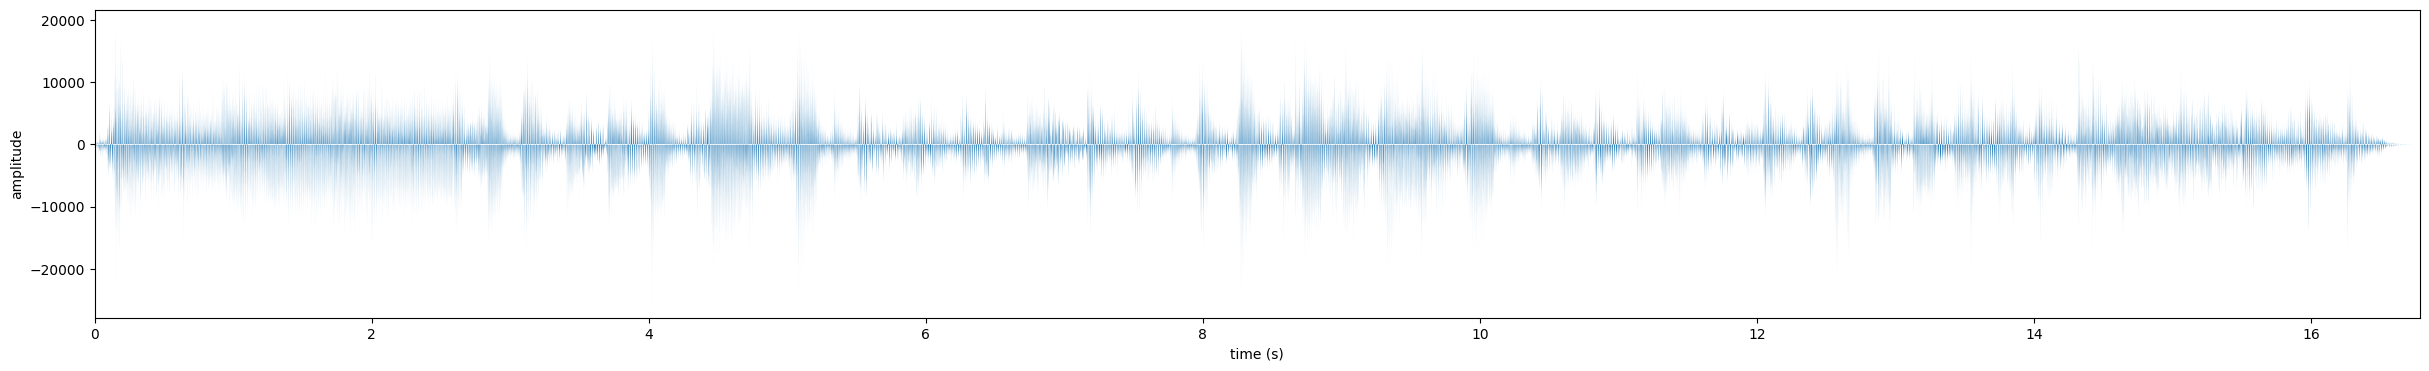

In [56]:
plot_sound(x, times)

### <ins>Part I : FIltering the signal</ins> 

1. <ins>Describe and draw the digital processing chain that will permit you to achieve such a conversion
(in particular you need to specify the characteristics of the filter H(z) that you will have to use).</ins>

$ \qquad \qquad \qquad \qquad \qquad \qquad \qquad x_{n} \iff \uparrow 2 \iff h_{n} \iff \downarrow 3 \iff y_{n}$ 

$ \qquad $ $h_{n}$ is a low-pass filter with a cutoff frequency of $16KHz$ ( i.e $\frac{96000KHz}{6}$).
We begin by an upsampling and our signal's frequency is doubled, then we filter our signal to find the missing samples, at last we preform a downsampling to reach the desired frequency of $32KHz$  
 
In addition the filter $H(exp(2iπν))$ is a 'door' function with the following caracteristics:  
$\qquad \nu_{a} = \min(\frac{1}{2L},\frac{1}{2M}) = \frac{1}{6} $  
$\qquad \nu_{c} = \frac{1}{6}$  
   

2. <ins>Synthesize an impulse reponse $h_{n}$ appropriate for this conversion of sampling rate. You can use
the following implementations of the Remez method:</ins>

$\qquad$ Since we are on python, we will use the scipy module and its remez function, with the previous cutoff frquencies we compute the $h_{n}$ function, we get the following code:

/tmp/ipykernel_2325/3174523547.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


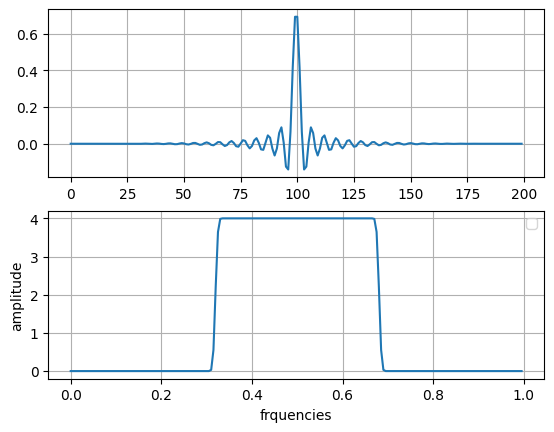

In [29]:
#Getting the remez function using scipy.signal

h =  scipy.signal.remez(200, [0, 1/6, 1/5 , 0.5], [2,0])
#Getting the fft of the function using numpy and computing the module squared

H = np.fft.fft(h)
H = np.fft.fftshift(H)
MODULEH =np.absolute(H)**2
#Plotting the results , hn and H module
fig , ax = plt.subplots(2)
ax[1].grid()
ax[0].grid()
ax[0].plot(h)
ax[1].plot(np.arange(len(MODULEH))/200,MODULEH)
plt.xlabel('frquencies')
plt.ylabel('amplitude')
plt.legend()
plt.show()

3. <ins>Program the simplest digital processing chain that will permit you to achieve the conversion. You
can use the Matlab function filter or the Python function scipy.signal.lfilter.</ins>

$\qquad$ Down below we introduce functions that downsample or upsample with certain steps that the user chooses. Following the TP, we should choose the {2,3} as our steps. These functions have been optimized using all of numpy's functions.

In [30]:
def oversample(X,step):
    oversampled = np.zeros(len(X) * step)
    oversampled[::step] = X  
    return oversampled


def downsampling(X,step):
    return X[::step]

Here we define the function that shall resample the signal following the TP exercise.

In [48]:
def filter(data):

#Oversampling our signal
    X_over = oversample(data,2)
    print("finished oversampling the signal")
#defining the hn filter
    h =  scipy.signal.remez(200, [0, 1/6, 1/5 , 0.5], [2,0])
    X_conv = scipy.signal.lfilter(h,[1],X_over)
    print("finished filtering the signal")
#Downsampling the signal
    X_down = downsampling(X_conv,3)
    print("finished Downsampling the signal")
    return X_down

Let us now upload the music in a "new_caravan.wav" file in order to test it

In [59]:
X = filter(data)
write('new_caravan.wav', Fs, np.array(X, dtype=np.int16)) # to write a new wave file
print("finished uploading music")
timestep = 1/float(Fs*2//3)
timestep_original = 1/float(Fs)
times = np.arange(len(X))*timestep
times_original = np.arange(len(x))*timestep_original

finished oversampling the signal
finished filtering the signal
finished DOwnsampling the signal
finished uploading music


Let us Plot both the original sound and resampled sound to compare.

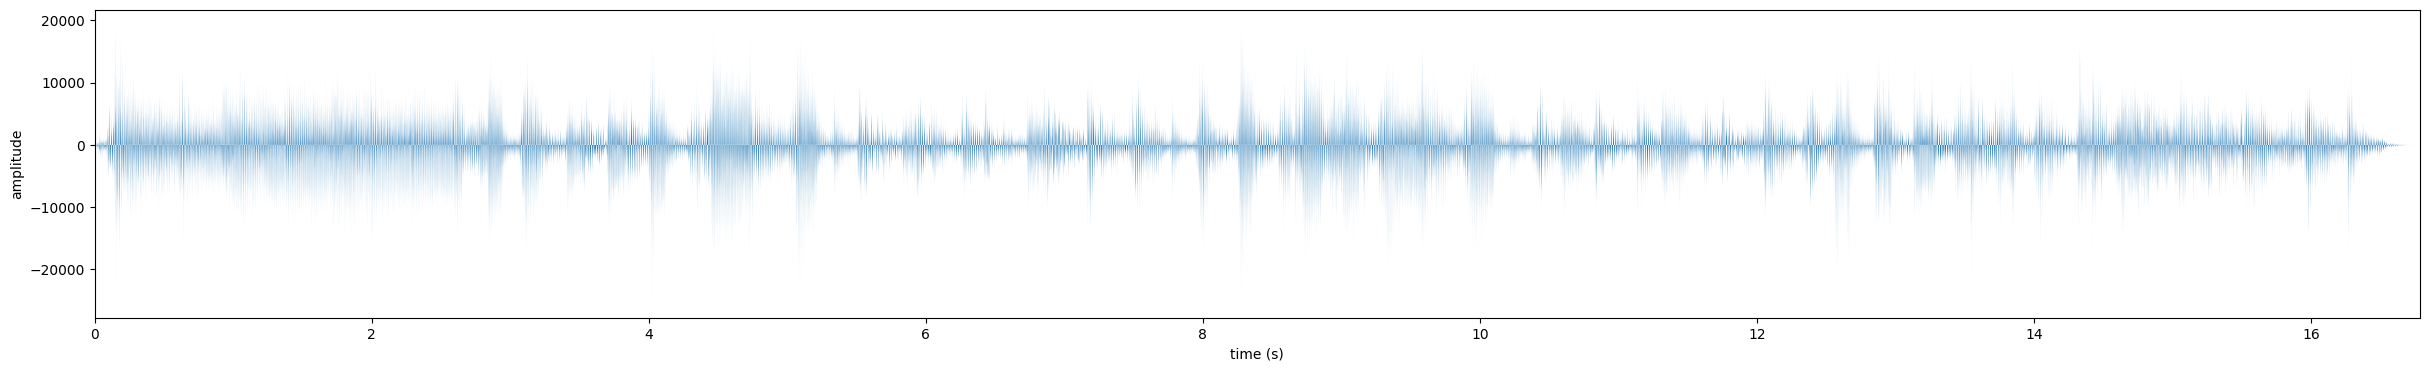

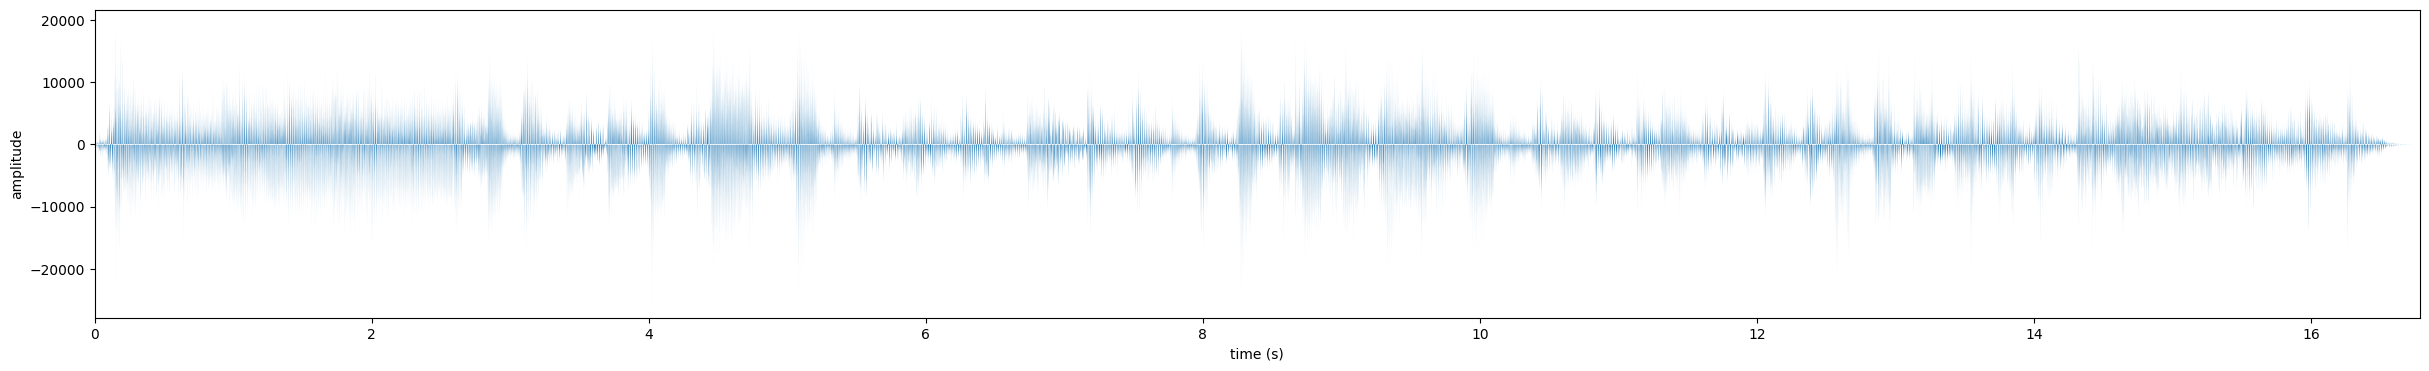

In [60]:
# Resampled signal
plot_sound(X,times)
#Original signal
plot_sound(x,times_original)

As we can see, 

4. <ins>Check and exploit the equivalence between the two diagrams of Figure 1.</ins>  

The following figures are equivalent:  
    $ \qquad z \iff \downarrow 3 \iff \uparrow 2 \iff z^{-1} $  
    $\qquad \qquad \Updownarrow$  
    $ \qquad z \iff \uparrow 2 \iff \downarrow 3 \iff z^{-1} $  
    $\qquad \qquad \Updownarrow$  
    $ \qquad \uparrow 2 \iff z^{2} \iff z^{-3} \iff \downarrow 3 $   
    $\qquad \qquad \Updownarrow$  
    $\qquad \uparrow 2 \iff z^{-1} \iff \downarrow 3$

We thus find the proposed equivalence.
    

We compute down below the functions, both optimized and unoptimized, of the signal. Using the Pollyphase functions , we define :

In [68]:
def unoptimized_shift(X,step1,step2):
    #counting the execution
    start = time.time()
    #Getting the remez function
    h = scipy.signal.remez(200,[0,0.14,0.16,0.5],[2 ,0])
    #Implementing the polyphases
    E_0 = h[::2]
    E_1 = h[1::2]
    E_1 = np.roll(E_1,1)

    #Filtering the signal
    X_over = oversample(X, step1)
    X_result = scipy.signal.lfilter(E_0,[1],X_over) + scipy.signal.lfilter(E_1,[1],X_over)
    X_result = downsampling(X_result,step2)
    end = time.time()

    #Getting the execution time
    print(f"Execution time of the unoptimized function : {end-start}")
    return X_result

In [66]:
def optimized_shift(X,step1, step2):
    #Starrting the countdown
    start = time.time()
    #Getting the remez function
    h = scipy.signal.remez(200,[0,0.14,0.16,0.5],[2 ,0])
    E_0 = h[::2]
    E_1 = h[1::2]
    X = X.astype(float)
    #Filtering the signals before sampling them
    X_1 = scipy.signal.lfilter(E_0,[1],X)
    X_2 = scipy.signal.lfilter(E_1,[1],X)
    #Sampling the signals
    X_1 = oversample(X_1, step=step1)
    X_2 = oversample(X_2, step=step1)
    X_2 = np.roll(X_2, 1)
    X_out = X_1 + X_2
    X_out = downsampling(X_out, step=step2)
    end = time.time()
    #Getting the execution time
    print(f"Exectuion time of the optimized function: {end-start}")
    return X_out

In [75]:
#compute the outputs and compare the execution time
X_unoptimized = unoptimized_shift(X=x,step1= 2,step2 = 3)
X_optimized = optimized_shift(X=x,step1=2, step2 = 3)

Execution time of the unoptimized function : 0.0987710952758789
Exectuion time of the optimized function: 0.04630327224731445


As we can see, there seems to be a small difference between the two, only $\bold 0.06s !$. However, this is only for  remez of 200, we will see huge differences when we start increasing the number of points of out $h_{n}$ !.

### <ins>Part II: STFT audio Equalizer</ins>

1. <ins>We choose w(n) as a Hann (Hanning) window of length Nw. Plot the DFT of w, i.e. ˆw(k/M) where
M, M ≥ Nw is the order of the DFT. What is the width of the main lobe as a function of Nw 

Down below we plot the Hanning window of lenght $N_{w}$ and with a number M for the TFD, higher than $N_{w}
$

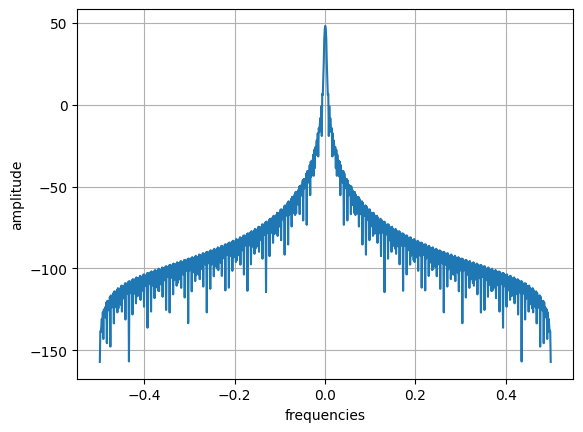

In [82]:

#Let us choose Nw and M
Nw = 512
M = 900 # ordre de la tfd

#Let us call the hanning function of width Nw
w = np.hanning(Nw)

#Compute the tfd of M points
TFW = np.fft.fft(w,M)
TFW = np.abs(np.fft.fftshift(TFW))
mu = np.linspace(-0.5,0.5, M)

#We will plot this function logarithmicly
with np.errstate(divide='ignore', invalid='ignore'):
    TFW = 20 * np.log10(TFW)


indexes = np.arange(len(TFW))

plt.grid()
plt.plot(mu[1:],TFW[1:])
plt.xlabel('frequencies')
plt.ylabel('amplitude')
plt.show()

We define the following function    

$\begin{align} W_{x}(\lambda,b) = \Sigma_{n \in \Z} x_{n}w_{n-b}e^{2i\pi\lambda n} \end{align}$ 

2. <ins>Note that the expression (1), taken at fixed λ, can be written as a convolution and deduce an inter-
pretation of the STFT in terms of filtering. Explain the role of the corresponding filter (low-pass?
band-pass? high-pass?). As a linear phase FIR filter, specify its type (type 1,2,3,4?) according to
its length (even or odd).

The expression 1 , can be expressed as follows :  
    $\begin{align} W_{x}(\lambda,b)   = \widehat{x\star (w\star\delta_{b})}(\lambda) \end{align}$   
    with $\widehat{f}$ expressing the Fourier transform of the function.  
    We can deduce then that $W_{x}$ plays the role of a filter , as we are computing the fourier transform of the function.  
    The hanning function $w$ is even, and with an odd lenght, we can deduce then that this is a low-pass , first order Filter.

3. Another definition of the STFT, referred to as "band-pass convention", is given by :  
$\begin{align}\tilde{X}(\lambda,b) = \Sigma_{n \in \Z} x_{n+b}w_{n}e^{2i\pi\lambda n} \end{align}$

We can see that it resembles the last definition. However, this time instead of shifting gradually the window, we shift the signal. We move the signal while leaving the hanning window fixed ! 

The code is an implementation of the function, notice how in the $for$ loop, we slicing the signal matrix while not modifying the Hanning window function. This TP implementation is then the one of : $\tilde{X}$

4. <ins>Based on the Matlab script stft.m or on the Python notebook template, for M = 32 and R = 1,
compute the signal xk(u) = ˜X(k, u), for k = 3. Is it real or complex ? Check the interpretation in
terms of filtering by using the Matlab functions filter and spectrogram or the Python functions
scipy.signal.lfilter and scipy.signal.spectrogram. Listen to Re(xk)

In [85]:
#Let us define the variables
N = x.shape[0] # % longueur du signal

#We will use a window on width 512
Nw = 512    
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse

#The R will be equal to 1 Here
R = 1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR

#M is 32 in this case !
M = 32 # ordre de la tfd
L = int((M/2) + 1)


affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((L,Nt),dtype=complex)

########################################## Main Loop ########################################

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,L) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    
    h = [M, [0, -1/6, 1/6, 0.5] , ]

    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

#Print the Xtilde Variable for k = 3

print(Xtilde[:,3])


[-0.055703  +0.j         -0.00735672-0.02653209j -0.0125616 -0.0037382j
 -0.01333103-0.03240664j  0.01044847-0.02504603j  0.01592196-0.00487241j
  0.01016456-0.01547488j  0.01221455+0.00531722j  0.01235131-0.00921719j
  0.01235131+0.00921719j  0.01221455-0.00531722j  0.01016456+0.01547488j
  0.01592196+0.00487241j  0.01044847+0.02504603j -0.01333103+0.03240664j
 -0.0125616 +0.0037382j  -0.00735672+0.02653209j]


With the loop above, we get the $\tilde{X}$ function, the Fourier transform of 32 Points. As we can see, it is a complex number, so from now on we will take the real part of our signal.  
We write the music in a file name called (obviously): "STFT_noise"

In [88]:
#Plotting and saving the real part of the third fourier transform
music = True
if music: 
    print("Writing music on file")
    write('STFT_noise.wav', Fs, np.array(np.real(Xtilde[3, :]), dtype=np.int16)) # to write a new wave file
    file_path = 'STFT_noise.wav'

Writing music on file


We now plot the Freqiencies of the signal using scipy.signal.spectrogram (The code below is importedd from the official documentation)

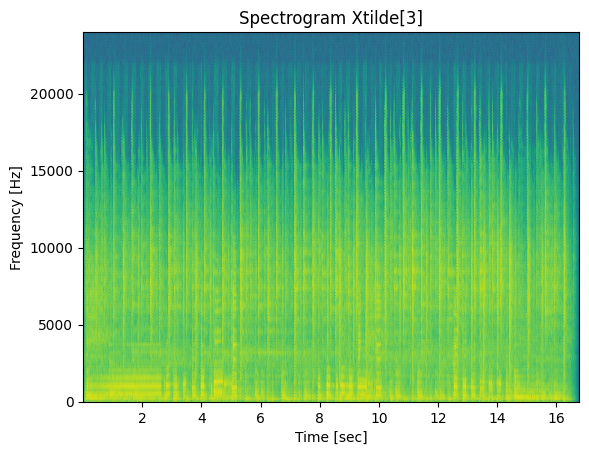

In [91]:
#Plotting the spectrogram of the signal, logarithmically 
f, t , Sxx = scipy.signal.spectrogram(np.real(Xtilde[3 , : ]),Fs)
plt.pcolormesh(t, f, 20*np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram of Xtilde[3]")
plt.show()


Here , we plot the Spectrogram of the original signal, in order to compare it to the Xtilde one.

/tmp/ipykernel_2325/4044210539.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',


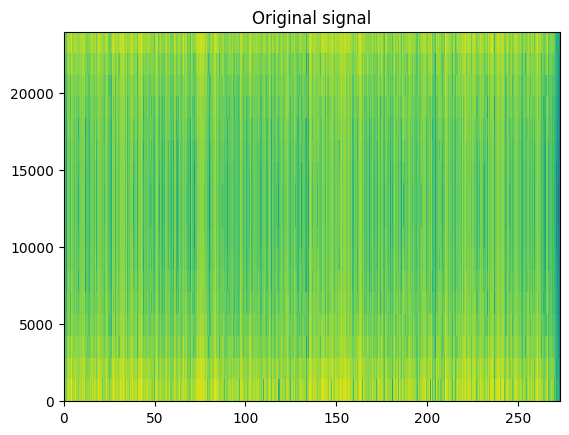

In [94]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    plt.title("Original signal")

As we can see, the signals looks almost alike! However, the amplitude of $\tilde{X}$ is lower and it is not as rich in frequencies as the original one.

#### <ins>Reconstruction:

We define the following function :
    $\begin{align} y_{n} = \Sigma_{u\in\Z}y_s(u,n-uR) \end{align}$
    where $y_{s} = DFT^{-1}(\tilde{X})(n) w_s(n) = \frac{1}{M}\Sigma_{k = 0}^{M}\tilde{X}(k,u)e^{2j\pi \frac{kn}{M}}w(n)$

5. Show that a sufficient condition for perfect reconstruction is $f(n) = 1 \forall n \in \N$ where $f(n) = \Sigma_{u\in \Z} w(n −
uR)ws(n − uR)$. Use the program ola.m or function ola in the notebook template to check this
condition for the product window $w_p(n) = w(n)w_s(n) = h(n)$, where $h(n)$ is a Hann window
correctly normalized, and for a 75% overlap.  

We know using the last expression that $\begin{align} y_{n} = \Sigma_{u\in\Z}y_w(u,n-uR) \cdot w_s(n-uR) \end{align}$ with 
$y_w(u, n-uR) =  \frac{1}{M}\Sigma_{k = 0}^{M}\tilde{X}(n-uR,u)e^{2j\pi \frac{kn}{M}}$

Let us now prove the assertion :

$\begin{align} y_n = \Sigma_{u\in\Z}w_s(u,n-uR)\cdot \frac{1}{M}\Sigma_{k=0}^{M-1}\tilde{X}(n-uR,u)e^{2j\pi \frac{kn}{M}}\\ =  \Sigma_{u\in\Z}w_s(u,n-uR)\cdot \frac{1}{M}\Sigma_{k=0}^{M-1}\Sigma_{l=0}^{M}w(l-uR)x(l)e^{2j\pi(n-uR)\frac{l}{M}}  e^{2j\pi \frac{kn}{M}}
\\= \Sigma_{u \in Z}w_s(n-uR)\Sigma_{k=0}^{M-1}w(k)x(k+uR) \mathbb{1}_{n-k-(n-uR)}\\ =\Sigma_{u \in Z}w_s(n-uR)w(n-uR) \cdot x(n)\end{align}$  

We then conclude that if $y_n = x_n$, $\Sigma_{u \in Z}w_s(n-uR)w(n-uR) = 1 \forall n \in \N$


Down below is the OLA function, this one will be used to reconstruct, we will firstly rebuild the hanning window $h_n$ using this method, we then will move to reconstrcting the $\tilde{X}$ as a whole.

The exxercise specifies that $w(n)\cdot w_s(n) = h(n)^2$, using the reconstruction condition to the hanning window, gives a a simple condition

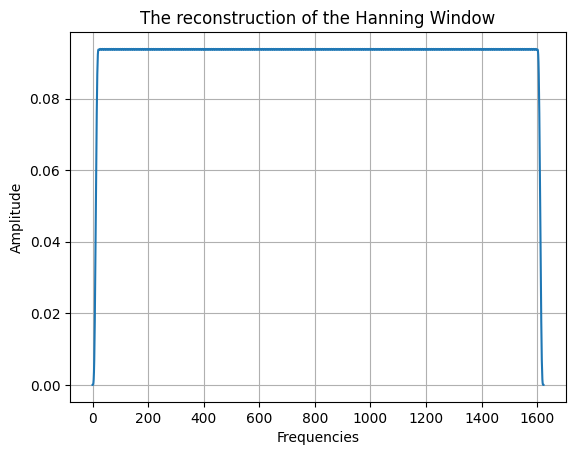

In [105]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

############################# Main Loop #######################################

M = 32
w = np.hanning(M)
H = np.sum(w)

h = w/np.sqrt(H)
Hanning = ola(h**2, int(0.25*M),200)
plt.grid()
plt.plot(Hanning)
plt.xlabel('Frequencies')
plt.title("The reconstruction of the Hanning Window")
plt.ylabel('Amplitude')
plt.show()


/tmp/ipykernel_114572/1665022471.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  y_s[:, u] = np.fft.ifft((Xtilde[:, u]),L) * h


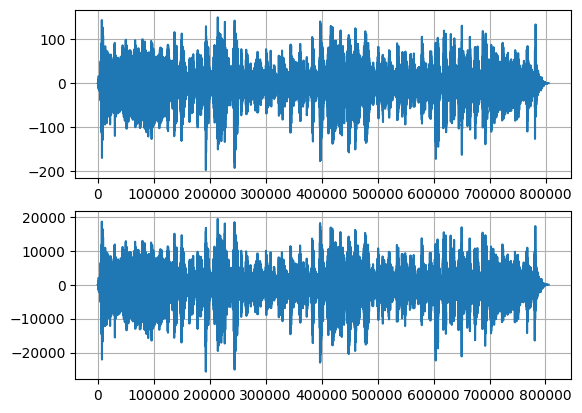

In [142]:
N = x.shape[0] # % longueur du signal
Nw = 16
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R =1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 32 # ordre de la tfd
L = int(M/2 + 1) #Channels
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)


#signal reconstruction
y_s = np.zeros(Xtilde.shape)

for u in range(Xtilde.shape[1]) :
    y_s[:, u] = np.fft.ifft((Xtilde[:, u]),L) * h

reconstruction = np.zeros(Nw + y_s.shape[1])

for k in np.arange(0, y_s.shape[1]).reshape(-1) :
    deb = k*R
    fin = deb + Nw
    reconstruction[np.arange(deb, fin)] = reconstruction[np.arange(deb, fin)] + y_s[:Nw, k]

fig , ax = plt.subplots(2)
ax[0].grid()
ax[1].grid()
ax[0].plot(reconstruction, label="reconstructed sinal")
ax[1].plot(x, label='real signal')
plt.show()

In [46]:
write('reconstructed_noise.wav', Fs, np.array(np.real(reconstruction), dtype=np.int16)) # to write a new wave file

NameError: name 'reconstruction' is not defined